# Basic Code
This code is a first test of implementing the Kleinman Alogrithm for the model free controller.

This code will try to control the height of a drone.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
import control as ct
import control.matlab as matlab
from HelperFunctions import *

In [2]:
# Define the Space state model. X = [x, x_dot] U = [u*] Y = [x], x = [height], u* = [thrust + gravity]
# Gravity applied only to Z double dot

A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

ss_ = ct.ss(A, B, C, D)
tf_ = ct.ss2tf(ss_)

g = 9.81

In [3]:
B_cont=ct.ctrb(A, B)
rank = np.linalg.matrix_rank(B_cont)

if rank == np.size(A,0):
    print("The system is controllable")
else:
    print("The system is not controllable")

The system is controllable


In [4]:
noise_T = np.random.normal(loc=0.0, scale=5, size=1000)
random_T = g + noise_T 
np.median(random_T)

9.871152850740609

# Optimal control:
The closed loop system is defined as:
$\dot{x} = (A-BK)x(t),  x(0) =x_0$

The solution of x(t) is:

$x(t) = e^{(A-BK)t}x_0$

The cost function is defined as:

$J = \int_0^\infty (x^T Q x + u^T R u)dt$

By submiting u=-Kx into the cost function we get:

$J = \int_0^\infty (x^T (Q + K^T R K) x)dt$

By submitting the solution of x(t) into the cost function we get:

$J = x_0^T*(\int_0^\infty(e^{(A-BK)^Tt}\cdot(Q+K^TRK)\cdot e^{(A-BK)t})dt)x_0$

Definition: 

$ P = \int_0^\infty(e^{(A-BK)^Tt}\cdot(Q+K^TRK)\cdot e^{(A-BK)t})dt$

So the cost function is:

$J = x_0^T\cdot P\cdot x_0$

The minimal P can be obraint by solving the Lyapunov equation.
The Lyapunov equation for a closed loop system is defined as:

$(A-BK)^T P + P(A-BK) + Q - K^TRK= 0$

We cant solve this equation because we dont know K. We find K from the Riccati equation.
The Riccati equation is defined as:

$A^T P + PA - PBR^{-1}B^T P + Q = 0$

We can solve this equation for P and then find K from the equation:

$K = R^{-1}B^T P$

# Kleinman Algorithm
The Kleinman Algorithm is a method to solve the Riccati equation for a given A, B, Q and R matrix.
The algorithm is iterative and starts with a stabilizing control value K.

The optimal controller is found by solving the Riccati equation and then finding K from the equation $K = R^{-1}B^T P$

This equation is qubic in respect to P. Lyapunov equation in the other hand as linear in respect to P.

We can solve iteratively by starting with stabilizing control value K -> Solving Lyapunov equation (P) -> Updating K

The algorithm is defined as:

1. Start with a stabilizing control value K
2. Solve the Lyapunov equation for P
3. Update K
4. Check if the solution is converging
5. If not converging go back to step 2
6. If converging the solution is found
7. Find the optimal controller K from the equation $K = R^{-1}B^T P$
8. The optimal controller is found

## Starting with the basic LQR controller:

In [5]:
Q_lqr = np.array([[1, 0], [0, 1]])
R_lqr = 1
K_lqr, P_lqr, E = matlab.lqr(A, B, Q_lqr, R_lqr)
print('Computed Controller based on LQR: K = ', K_lqr)
print('Computed P based on LQR: P = ', P_lqr)

Computed Controller based on LQR: K =  [[1.         1.73205081]]
Computed P based on LQR: P =  [[1.73205081 1.        ]
 [1.         1.73205081]]


## Kleinman Algorithm

In [6]:
Q = np.array([[1, 0], [0, 1]])
R = 1
R_ = np.array([[1]])
# Define the number of iterations
iterations = 100

# Define the convergence value
convergence = 0.01

# Define the initial value of P
P_kleinman = []
P_old = np.zeros_like(A)

# Define the initial value of K
K_ = 0.1 * K_lqr
K_kleinman = []


In [7]:
# Starting the loop:
for i in range(iterations):
    # Solve the Lyapunov equation of the closed loop system
    # Q_bar = Q + K_.T * R * K_
    Q_bar = Q + K_.T @ R_ @ K_
    A_bar = A - B @ K_
    # Need A^T because the function is calculating based on the transpose of what we want.
    P_ = matlab.lyap(A_bar.T, Q_bar)
    P_kleinman.append(P_)
    # Update K
    # K_ = R**-1 * B.T @ P_
    K_ = np.linalg.inv(R_) @ B.T @ P_
    K_kleinman.append(K_)
    
    # Check if the solution is converging
    if abs(np.linalg.det(P_ - P_old)) < convergence:
        print("converged")
        break
    P_old = P_


converged


In [8]:
print('Computed Controller based on Kleinman: K = ', K_kleinman[-1])
print('Computed P based on Kleinman: P = ', P_kleinman[-1])
print('Number of iterations: ', np.size(P_kleinman,0))

Computed Controller based on Kleinman: K =  [[1.        1.7320548]]
Computed P based on Kleinman: P =  [[1.7320548 1.       ]
 [1.        1.7320548]]
Number of iterations:  8


In [9]:
K_kleinman = np.array(K_kleinman)
P_kleinman = np.array(P_kleinman)

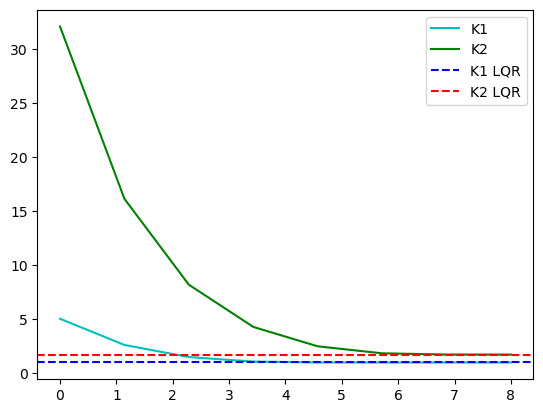

In [10]:
iterations = np.size(P_kleinman,0)
t = np.linspace(0, iterations, iterations)
plt.plot(t,K_kleinman[:,0,0], label='K1', color='c')
plt.plot(t,K_kleinman[:,0,1], label='K2', color='g')

# Adding the LQR controller as horizontal lines:
plt.axhline(y=K_lqr[0,0], color='b', linestyle='--', label='K1 LQR')
plt.axhline(y=K_lqr[0,1], color='r', linestyle='--', label='K2 LQR')

plt.legend()


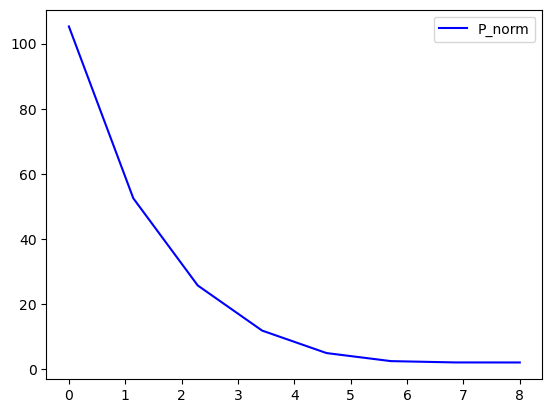

In [11]:
P_norm = np.linalg.det(P_kleinman)

plt.plot(t,P_norm, label='P_norm', color='b')
plt.legend()

# Model Free Case:

In this case we dont know the model of the system.
Our original system is defined as:

$\dot{x} = Ax + Bu$

We can define a new system as:

$\dot{x} = Ax + Bu_i +B(u-u_i)$

where $u_i = -K_ix$ is the optimal control input.

When calculating the value function based on this model:

$V_i(t) = x^T P_i x = \int_t^\infty(x^TQx+u_i^TTu_i)dt$

After applying the optimal control input we get:

$V_i(t) = x^T P_i x = \int_t^\infty(x^TQx+(K_ix)^TR(K_ix))dt$

$V_i(t) = x^T P_i x = \int_t^\infty(x^TQx+x^T(K^TRK)x)dt$

From the first equality the derivative of the value function is:

$\dot{V_i}(t) = 2x^T(t)P_i\dot{x}(t)$

Replacing $\dot{x}$ with the original system we get:

$\dot{V_i}(t) = 2x^T(t)P_i(Ax(t)+Bu_i+B(u-u_i))$

With the control input:

$\dot{V_i}(t) = 2x^T(t)P_i(Ax(t)-BK_ix+B(u+K_ix))$

Or: 

$\dot{V_i}(t) = \underset{\text{Scaler}}{\underbrace{2x^T(t)P_i(A-BK_i)x}}+\underset{\text{Scaler}}\underbrace{{2x^T(t)P_iB(u+K_ix)}}$



We can take the last expression of $\dot{V_i}(t)$ and rewrite it:

$\dot{V_i}(t) = x^T(t)((A-BK_i)P_i + P_i(A-BK_i))x(t) + 2(u+K_ix)^TB^TP_ix$

Using Lyapunov equation:

$(A-BK_i)^TP_i + P_i(A-BK_i) + Q K_i^TRK_i= 0$

We can rewrite the equation as:

$\dot{V_i}(t) = -x^T(t)(Q+K_i^TRK_i)x(t) 2(u+K_ix)^TB^TP_ix = -x^TQ_ix + 2(u+K_ix)^TB^TP_ix$

Where $Q_i = Q + K_i^TRK_i$

Now we eliminated A from the equation.

Using $ K_{i+1} = R^{-1}B^TP_i$ from kleinman algorithm we get: 

$B^TP = RK_{i+1}$

And the value function:

$\dot{V_i}(t) = -x^TQ_ix + 2(u+K_ix)^TRK_{i+1}x = -x^TQ_ix + 2u^TRK_{i+1}x+2x^TK_i^TRK_{i+1}x$

By integrating both sides we get in the LHS

$\int_t^{t+T} \dot{V_i}(t)d\tau = V_i(t+T) - V_i(t) = x^T(t+T)P_ix(t+T) - x^T(t)P_ix(t)$

This is the difference in the value function between 2 time steps.

In the RHS we get:

$\int_t^{t+T} -x^TQ_ix d\tau + 2\int_t^{t+T} u^TRK_{i+1}x d\tau + 2\int_t^{t+T} x^TK_i^TRK_{i+1}x d\tau$

The variables here are: $K_{i+1}$ and $P_i$

$K_i$ obtained in the last iteration

In this equation we dont have A or B, the model is not needed.

In order to calculate K and P we need data. We need to collect data from the system and calculate the value function.

Based on Kronecker product we can calculate the variables K and P.

All the calculations of the new equations are in Optimal Control 2 -pages 31,32 


Along a time period $[t_o, t_f]$ we need to have the following data:

the state vector:

$X = [x(t_o), x(t_o+T), x(t_o+2T), ..., x(t_f)]$

The input vector:

$U = [u(t_o), u(t_o+T), u(t_o+2T), ..., u(t_f)]$

\begin{figure}[h]
    \includegraphics[width=0.5\textwidth]{/Users/amitgedj/Library/CloudStorage/OneDrive-Personal/University/MsC/Thesis/Theory Codes/ADP - Drone height control/Kronecker 1.png}
    \includegraphics[width=0.5\textwidth]{/Users/amitgedj/Library/CloudStorage/OneDrive-Personal/University/MsC/Thesis/Theory Codes/ADP - Drone height control/Kronecker 2.png}
\end{figure}


Where $ Q_i = Q+K_i^TRK_i$

In [12]:
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

ss_ = ct.ss(A, B, C, D)
tf_ = ct.ss2tf(ss_)

g = 9.81



In [13]:
# Defining number of iterations:
iterations = 1000

#defining the inputs for the data collection:
T = 0.1
t = np.linspace(0, iterations, iterations)
u = np.random.normal(loc=0.0, scale=0.5, size=iterations) +9.81 # Might not need to add g because we are working with u* and not u

In [14]:
# finding the state vector for each input:
x_dot = np.zeros((2, iterations))
x = np.zeros((2, iterations))
x_dot[:,0] = np.array([0, 0])
x[:,0] = np.array([0, 0])
for i in range(1, iterations):
    x_dot[:,i] = (A @ x[:,i-1].reshape(-1,1) + B * u[i-1]).flatten()
    x[:,i] = x[:,i-1] + x_dot[:,i] * T

Now we have a series of data. 

Input U and the state vector x.

$x = {z, \dot{z}}$

z calculated based on euler integration

Starting the loops for calculating the controller:

In [15]:
(np.size(x,0)**2 + np.size(x,0))//2 + np.size(x,0)

5

In [16]:
kron_xx = np.empty((0, np.size(x,0)**2))
kron_xu = np.empty((0, np.size(x,0)))
delta_x = np.empty((0, np.size(x,0)**2))
Ixx = np.empty((0, np.size(x,0)**2)) # Initialize as an empty 2D array with shape (0, 2)
Ixu = np.empty((0, np.size(x,0)))
dT = np.arange(0,iterations*T+T,T)
l = np.size(x,0)*(np.size(x,0)+1)//2+np.size(x,0)*1 # u is scalar so m=1. we have 2 states, therefore 2 equations. Q is 2x2. defining l this way will help us to set the window of the integrations in order to get a valid dimensions for Ixx and Ixu
intr = int(iterations//(l +1)) # defining the interval for the integrations. this interval will give us Ixx and Ixu with the ammount of equations needed. In our case 2 equations.

for i in range(intr,iterations, intr):
    x_i = x[:,i]
    x_i_1 = x[:,i-intr]
    delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
    delta_x = np.vstack((delta_x, [delta_xx_i]))

    
for i in range(0,iterations):
    x_i = x[:,i]
    u_i = u[i]
    kron_xx_i = np.kron(x_i, x_i)
    kron_xu_i = np.kron(x_i, u_i)
    kron_xx = np.vstack((kron_xx, [kron_xx_i]))
    kron_xu = np.vstack((kron_xu, [kron_xu_i]))

for i in range(intr,iterations, intr):
    window = slice(max(0, i-intr), i+1)  # This defines the time steps t0 to t1 etc.
    new_Ixu = np.trapz(kron_xu[window,:], dT[window], axis = 0)
    new_Ixx = np.trapz(kron_xx[window,:], dT[window], axis =0)
    Ixu = np.vstack((Ixu, [new_Ixu]))
    Ixx = np.vstack((Ixx, [new_Ixx]))

given the dimension of P is 2x2, the N matrix is $n^2 \times (n^2+n)/2$

in this case n = 2, therfore N is 4x3

Now that we have the matrices $\delta_xx, Ixx, Ixu$ , and we have the ability to calculate the matrix N, vec and svec, we can use the equation

$ X_i \cdot \Theta_i = Y_i $

In [17]:
iterations = 1000
n = np.size(x,0)
m = 1
Q = np.array([[1, 0], [0, 1]])
R_ = np.array([[1]])
K_i = 0.2 * K_lqr # starting with a stabilizing control value
N_ = create_N_matrix(n)

K_adp = np.empty((0, np.size(x,0)))
P_adp = []
P_i_old = np.zeros_like(Q)

norm_Pi = np.array([])

for i in range(1,iterations):
    # Calculating Q_i:
    Q_i = Q + K_i.T @ R_ @ K_i
    
    # Calculating Y_i:
    Y_i = -Ixx @ vec(Q_i) # Shai added - in the begining
    X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) -2*Ixu @ np.kron(np.eye(n), R_)))
    
    # Calculating Theta_i:
    Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
    
    vecP_i = N_ @ Theta_i[:(n**2-n*m + 1)]
    P_i = vec2matrix(vecP_i)
    norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
    
    K_i = Theta_i[(n**2-2*m+1):].reshape(K_lqr.shape)

    
    K_adp = np.vstack((K_adp, K_i))
    P_adp.append(P_i)
    
    if abs(np.linalg.norm(P_i_old - P_i)) < 0.01:
        print('Converged')
        
        break
    
    P_i_old = P_i
    

Converged


In [18]:
K_adp

array([[ 2.60010748, 13.03391331],
       [ 1.49235827,  6.73419063],
       [ 1.08122514,  3.69332231],
       [ 1.00305812,  2.40075166],
       [ 1.00001226,  2.04304465],
       [ 1.00000761,  2.01058893],
       [ 1.00000761,  2.01030316]])

In [19]:
K_lqr

array([[1.        , 1.73205081]])

Text(0, 0.5, 'Norm of P')

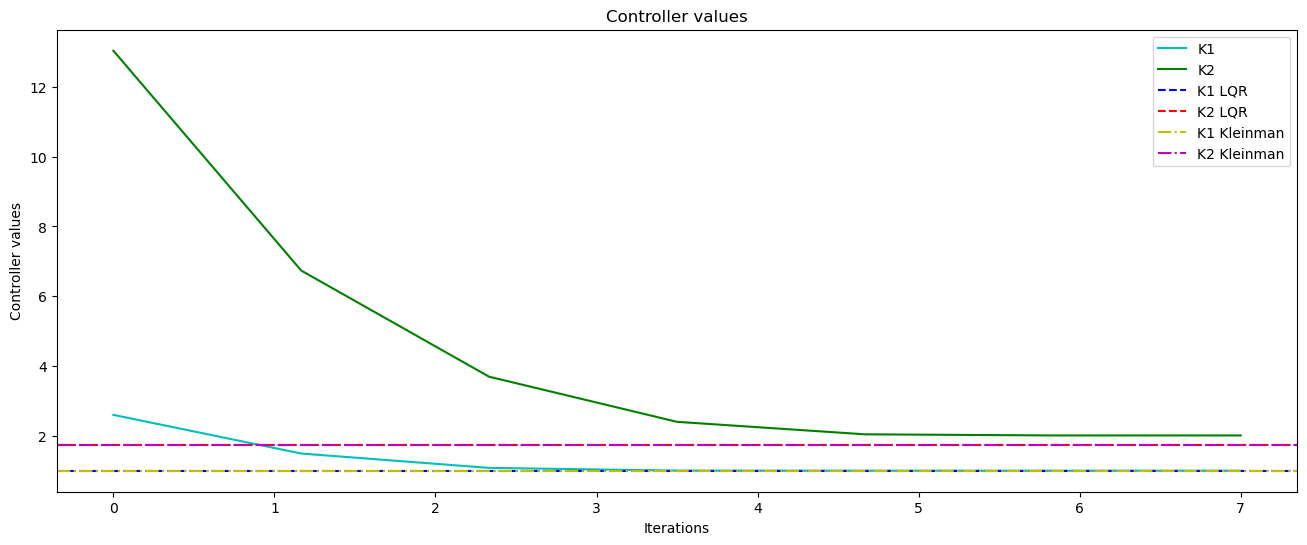

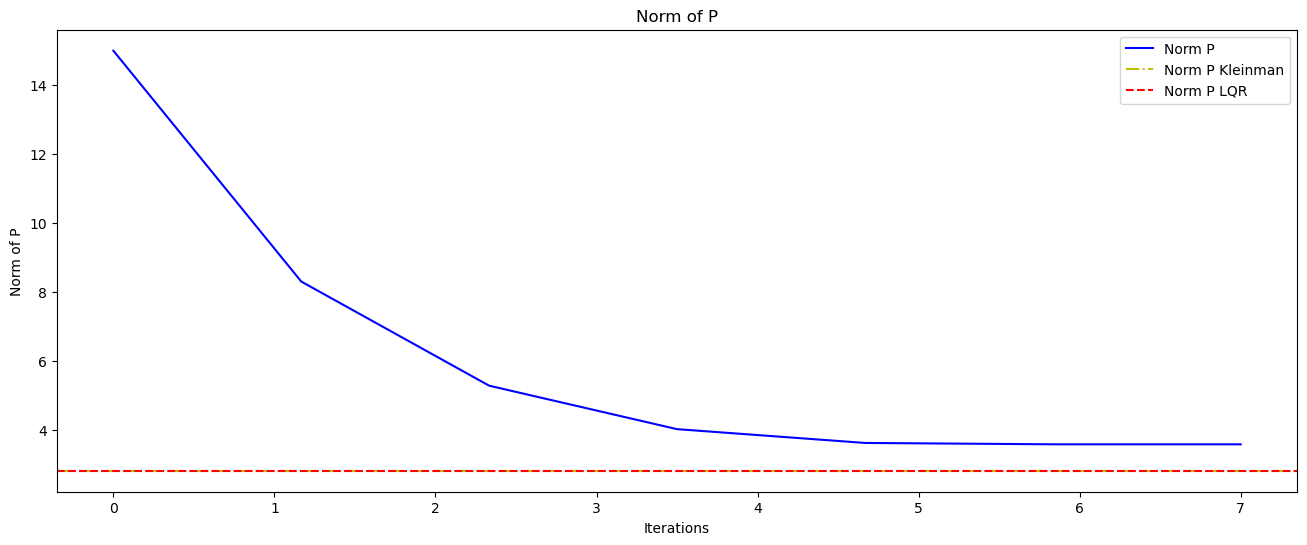

In [20]:
# Plotting the results:
plt.figure(figsize=(16,6))
iterations = np.size(P_adp,0)
t = np.linspace(0, iterations, iterations)
plt.plot(t,K_adp[:,0], label='K1', color='c')
plt.plot(t,K_adp[:,1], label='K2', color='g')

# Adding the LQR controller as horizontal lines:
plt.axhline(y=K_lqr[0,0], color='b', linestyle='--', label='K1 LQR')
plt.axhline(y=K_lqr[0,1], color='r', linestyle='--', label='K2 LQR')

# Adding the Kleinman controller as horizontal lines:
plt.axhline(y=K_kleinman[-1][0,0], color='y', linestyle='-.', label='K1 Kleinman')
plt.axhline(y=K_kleinman[-1][0,1], color='m', linestyle='-.', label='K2 Kleinman')

plt.legend()
plt.title('Controller values')
plt.xlabel('Iterations')
plt.ylabel('Controller values')

plt.figure(figsize=(16,6))

P_adp = np.array(P_adp)
iterations = np.size(P_adp,0)
t = np.linspace(0, iterations, iterations)
plt.plot(t,norm_Pi, label='Norm P', color='b')

# Adding the Kleinman controller as horizontal lines:
plt.axhline(y=np.linalg.norm(P_kleinman[-1]), color='y', linestyle='-.', label='Norm P Kleinman')
plt.axhline(y=np.linalg.norm(P_lqr), color='r', linestyle='--', label='Norm P LQR')

plt.legend()
plt.title('Norm of P')
plt.xlabel('Iterations')
plt.ylabel('Norm of P')



# Ask Shai:

1. Is there no weight on the input in the value function? I see only X in $Q_i$ and not $u_i$.
2. Why specifically Yi = -Yi? and Xi = -Xi? Anything other that that ruins the algorithm.